In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import linear_model
from sklearn import datasets
%matplotlib inline

In [2]:
data = datasets.load_diabetes()
X = data.data
y = data.target.reshape(-1,1)

In [3]:
df = pd.DataFrame(X, columns=data.feature_names)

In [4]:
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


## 劣勾配の可視化  
x = 0の点では、$傾き= [-1,1]$ の値を取る、ということを可視化する 

Text(0,0.5,'f(x)')

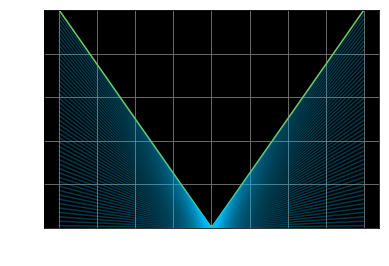

In [5]:
x = np.linspace(-1, 1, 100)
y = np.abs(x)
plt.plot(x,y)
for xi in x:
    plt.plot(x, xi*x, color="deepskyblue", alpha=0.3)
plt.ylim(0,1)
plt.xlabel("x")
plt.ylabel("f(x)")

## Soft thresholding function

In [137]:
def soft_threshold(p, lam):
    y = p.copy()
    y[p < -lam] += lam
    y[p > lam] -= lam
    y[(-lam <= p) & (p <= lam)] = 0
    return y
    

In [7]:
lam = 0.5
y = soft_threshold(x, lam)

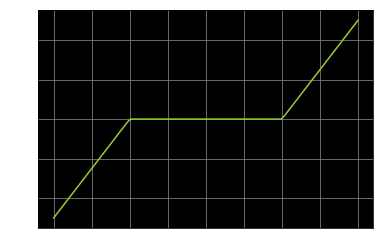

In [8]:
plt.plot(x,y)

## 確認用のデータをロード

In [126]:
data = datasets.load_diabetes()
X = data.data
y = data.target.reshape(-1,1)
df = pd.DataFrame(X, columns=data.feature_names)

## coordinate descentによるLasso

In [138]:
def coordinate_descent(X, y, theta, lam = 0.01, N = 100, tol=1e-4):
    
    if y.ndim != 2:
        y = y.reshape(-1,1)
    
    if theta.ndim != 2:
        theta = theta.reshape(-1, 1)
        
    m, n = X.shape
    theta_new = theta.copy()
    theta_old = theta.copy()
    for _ in range(N):
        for j in range(n): ## 特徴点ごとに個別に処理
            X_j = X[:, j].reshape(-1,1)
            y_pred = X @ theta_new ## k = jを含んでしまっている
            rho = X_j.T @ (y - y_pred + theta_new[j] * X_j) ## k=j を取り除く、ノート参照
            z = np.sum(X_j**2)
            theta_new[j] = soft_threshold(rho, lam) / z
            
        if (np.abs(theta_new -theta_old) < tol).all():
            return theta_new.flatten()
        theta_old = theta_new.copy()
        
    return theta_new.flatten()

In [139]:
lam = len(y)
theta = np.ones([X.shape[1], 1])

In [142]:
## 自作のlasso
initial_theta = np.ones((X.shape[1], 1))
coef = coordinate_descent(X, y, initial_theta, lam)
print(coef)

[  0.           0.         367.69962074   6.31276272   0.
   0.           0.           0.         307.60242294   0.        ]


In [141]:
## scikit-learnによるlasso
lasso = linear_model.Lasso(alpha=lam / len(y), fit_intercept=False)
lasso.fit(X, y)
print(lasso.intercept_)
print(lasso.coef_)

0.0
[  0.          -0.         367.70185207   6.30190419   0.
   0.          -0.           0.         307.6057       0.        ]


In [14]:
## lasso pathを描画
initial_theta = np.ones((X.shape[1], 1))
theta_list = []
lams = np.logspace(0,4,300)/10
for lam in lams:
    theta = coordinate_descent(X, y, initial_theta, lam)
    theta_list.append(theta)
theta_list = np.array(theta_list).T

In [15]:
## scikit-learnでのlasso, 係数は データ数で正規化されている
eps = 5e-6
alphas_lasso, coefs_lasso, _ = linear_model.lasso_path(X, y, eps, fit_intercept=False)

Text(0.5,1,'scikit-learn lasso')

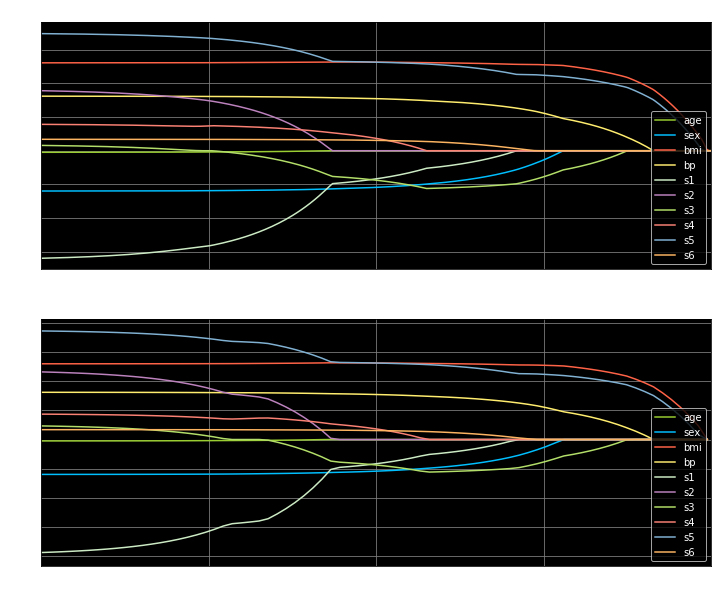

In [16]:
## lasso path を描画
figs, axs = plt.subplots(2,1, figsize=(12,10))
for theta, label_name in zip(theta_list, data.feature_names):
    axs[0].plot(lams, theta, label=label_name)
axs[0].set_xscale('log')
axs[0].legend(loc='lower right')
axs[0].set_xlim(10**-1, 10**3)
axs[0].set_title("my lasso [coordinate descent]")
for i in range(len(coefs_lasso[0])):
  # coefs_lasso[0]にしないとエラーが出る
  axs[1].plot(alphas_lasso*len(X), coefs_lasso[0][i], label = data.feature_names[i])
axs[1].set_xscale('log')
axs[1].legend(loc='lower right')
axs[1].set_xlim(10**-1, 10**3)
axs[1].set_title("scikit-learn lasso")


In [17]:
def supermum_eigen(A):
    return np.max(np.sum(np.abs(A), axis=0))

In [164]:
def ISTA(X, y, theta, lam = 0.01, N = 100, tol = 1e-4):
    
    if y.ndim != 2:
        y = y.reshape(-1,1)
    
    if theta.ndim != 2:
        theta = theta.reshape(-1, 1)
        
    m, n = X.shape
    grad_d = lambda x, y, the: -X.T @ (y - X @ the)
    rho = supermum_eigen(X.T @ X)
    theta_new = theta.copy()
    for _ in range(N):
        theta_new = soft_threshold(theta - grad_d(X,y,theta) / rho, lam/rho)
        if (np.abs(theta_new -theta) < tol).all():
            return theta_new.flatten()
        theta = theta_new
    return theta.flatten()

In [19]:
lam = len(y) ## データ個数
ISTA(X, y, initial_theta, lam=lam)

array([  0.        ,   0.        , 367.69903752,   6.31342758,
         0.        ,   0.        ,   0.        ,   0.        ,
       307.60236121,   0.        ])

In [20]:
coordinate_descent(X, y, initial_theta, lam)

array([  0.        ,   0.        , 367.69962074,   6.31276272,
         0.        ,   0.        ,   0.        ,   0.        ,
       307.60242294,   0.        ])

## Lasso path

In [45]:
def drawLassoPath(coef_list, lams, function_names, feature_names):
    function_num = len(coef_list)
    
    figs, axs = plt.subplots(function_num,1, figsize=(12,5*function_num))
    for i in range(function_num):
        for coef, label_name in zip(coef_list[i], feature_names):
            axs[i].plot(lams, coef, label=label_name)
            axs[i].set_xscale('log')
#             axs[i].legend(loc='lower right')
            axs[i].set_xlim(10**-1, 10**3)
            axs[i].set_ylim(-800, 800)
            axs[i].set_title("{}".format(function_names[i]))


In [22]:
## lasso pathを描画
initial_theta = np.ones((X.shape[1], 1))
lams = np.logspace(0,4,300)/10


In [23]:
lasso = linear_model.Lasso(alpha=lam / len(y), fit_intercept=False)
lasso.fit(X, y)
print(lasso.intercept_)
print(lasso.coef_)

0.0
[  0.          -0.         367.70185207   6.30190419   0.
   0.          -0.           0.         307.6057       0.        ]


In [24]:
## my coordinate descent
theta0_list, theta1_list, theta2_list = [], [], []
data_num = len(y)
coef_list = []
for lam in lams:
    theta0 = coordinate_descent(X, y, initial_theta, lam)
    theta1 = ISTA(X, y, initial_theta, lam)
    
    scikit_lasso = linear_model.Lasso(alpha=lam / data_num, fit_intercept=False)
    scikit_lasso.fit(X,y)
    theta2 = scikit_lasso.coef_
    
    theta0_list.append(theta0)
    theta1_list.append(theta1)
    theta2_list.append(theta2)
    
coef_list.append(np.array(theta0_list).T)
coef_list.append(np.array(theta1_list).T)
coef_list.append(np.array(theta2_list).T)


In [25]:
function_names = ["my coordinate_descent", "my ISTA", "scikit-learn lasso"]
feature_names = data.feature_names

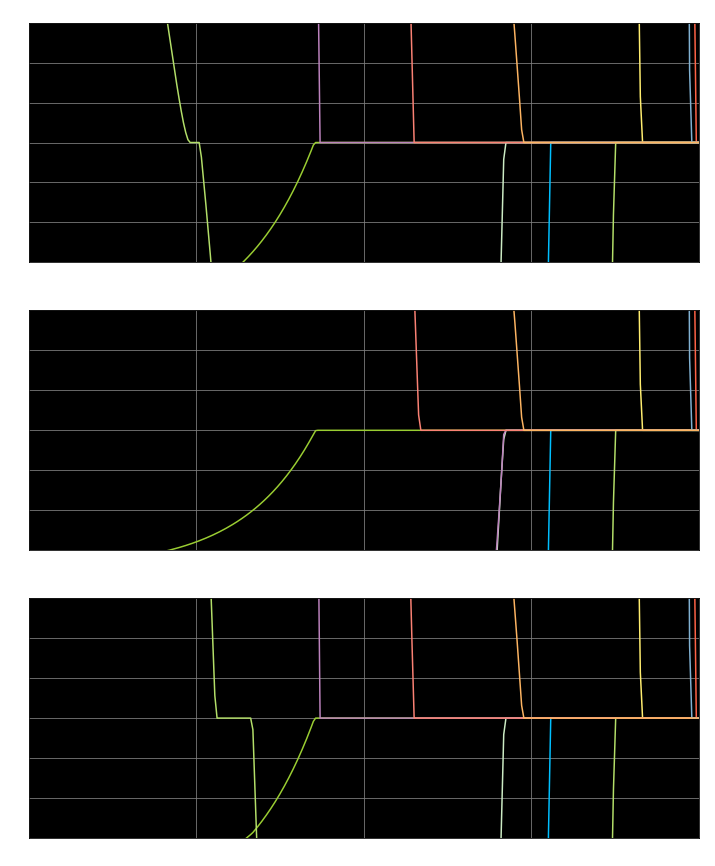

In [26]:
drawLassoPath(coef_list, lams, function_names, feature_names)

In [27]:
lam = len(y)

In [28]:
%time ISTA(X, y, initial_theta, lam, N=100, tol=1e-3)

CPU times: user 4.36 ms, sys: 1.36 ms, total: 5.71 ms
Wall time: 5.63 ms


array([  0.        ,   0.        , 367.69444088,   6.31951681,
         0.        ,   0.        ,   0.        ,   0.        ,
       307.60112953,   0.        ])

In [29]:
%time coordinate_descent(X, y, initial_theta, lam, N=100)

CPU times: user 8.96 ms, sys: 1.32 ms, total: 10.3 ms
Wall time: 10.8 ms


array([  0.        ,   0.        , 367.69962074,   6.31276272,
         0.        ,   0.        ,   0.        ,   0.        ,
       307.60242294,   0.        ])

In [30]:
scikit_lasso = linear_model.Lasso(alpha=lam / data_num, fit_intercept=False, max_iter=100, tol=1e-4)
%time scikit_lasso.fit(X,y)

CPU times: user 1.29 ms, sys: 1.06 ms, total: 2.35 ms
Wall time: 2.82 ms


Lasso(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=100,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [31]:
np.random.seed(42)

n_samples, n_features = 10000, 200
X = np.random.randn(n_samples, n_features)
coef = 3 * np.random.randn(n_features)
inds = np.arange(n_features)
np.random.shuffle(inds)
coef[inds[10:]] = 0  # sparsify coef
y = np.dot(X, coef)

# add noise
y += 0.01 * np.random.normal(size=n_samples)
y = y.reshape(-1,1)
initial_theta = np.ones((X.shape[1], 1))
lam = len(y)
data_num = len(y)

In [32]:
lams = np.logspace(0,4,100)/10

In [43]:
data = datasets.load_diabetes()
X = data.data
y = data.target.reshape(-1,1)
initial_theta = np.ones((X.shape[1], 1))

In [44]:
## my coordinate descent
theta0_list, theta1_list, theta2_list = [], [], []
data_num = len(y)
coef_list = []
for lam in lams:
    theta0 = coordinate_descent(X, y, initial_theta, lam)
    theta1 = ISTA(X, y, initial_theta, lam)
    
    scikit_lasso = linear_model.Lasso(alpha=lam / data_num, fit_intercept=False)
    scikit_lasso.fit(X,y)
    theta2 = scikit_lasso.coef_
    
    theta0_list.append(theta0)
    theta1_list.append(theta1)
    theta2_list.append(theta2)
    
coef_list.append(np.array(theta0_list).T)
coef_list.append(np.array(theta1_list).T)
coef_list.append(np.array(theta2_list).T)

In [35]:
feature_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

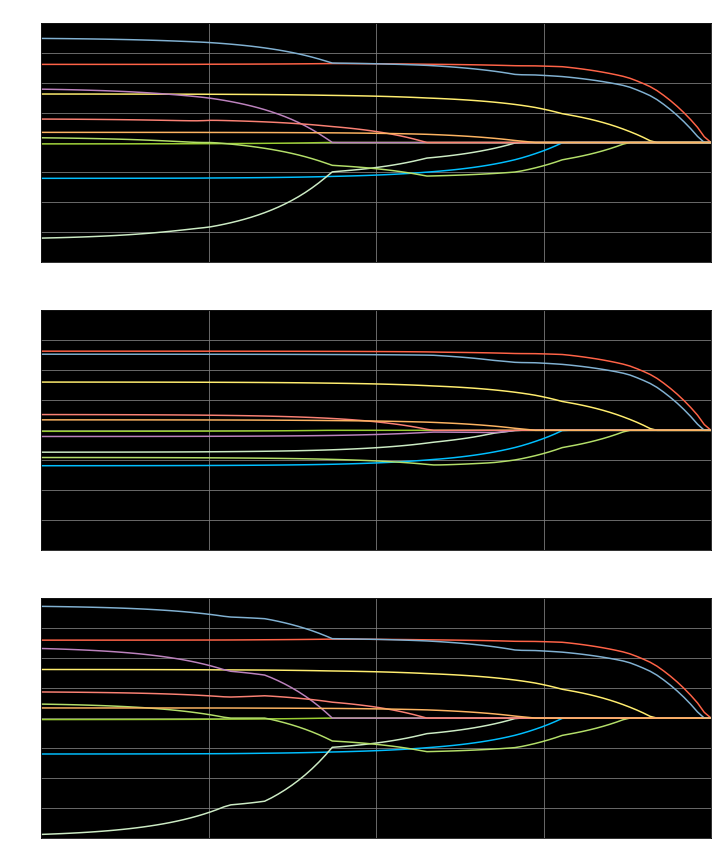

In [46]:
function_names = ["my coordinate_descent", "my ISTA", "scikit-learn lasso"]
feature_names = ["{}".format(s) for s in range(X.shape[1])]

drawLassoPath(coef_list, lams, function_names, feature_names)

In [47]:
lam = len(y) * 0.1
theta0 = coordinate_descent(X, y, initial_theta, lam, N=1000,tol=1e-5)
theta1 = ISTA(X, y, initial_theta, lam, N=10000,tol=1e-5)
scikit_lasso = linear_model.Lasso(alpha=0.1, fit_intercept=False,tol=1e-5, max_iter=1000)
scikit_lasso.fit(X,y)
theta2 = scikit_lasso.coef_

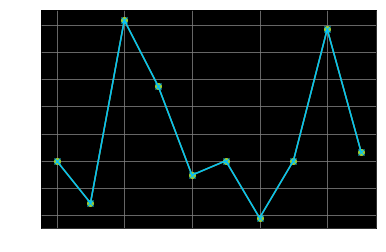

In [48]:
plt.plot(theta2, marker='o')
plt.plot(theta1, marker='x')
# plt.plot(theta0, marker='+')

In [39]:
%time _ = coordinate_descent(X, y, initial_theta, lam, N=10000,tol=1e-5)
%time _ = ISTA(X, y, initial_theta, lam, N=10000,tol=1e-5)
scikit_lasso = linear_model.Lasso(alpha=0.1, fit_intercept=False,tol=1e-5, max_iter=1000)
%time scikit_lasso.fit(X,y)

CPU times: user 1.84 s, sys: 66.9 ms, total: 1.91 s
Wall time: 1.07 s
CPU times: user 273 ms, sys: 37.6 ms, total: 311 ms
Wall time: 203 ms
CPU times: user 43.5 ms, sys: 4.15 ms, total: 47.7 ms
Wall time: 33.5 ms


Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=1e-05, warm_start=False)

In [163]:
def ISTA(X, y, theta, lam = 0.01, N = 100, tol = 1e-4):
    if y.ndim != 2:
        y = y.reshape(-1,1)
    
    if theta.ndim != 2:
        theta = theta.reshape(-1, 1)
        
    m, n = X.shape
    grad_d = lambda x, y, the: -X.T @ (y - X @ the)
    rho = supermum_eigen(X.T @ X)
    theta_new = theta.copy()
    for _ in range(N):
        theta_new = soft_threshold(theta - grad_d(X,y,theta) / rho, lam/rho)
        if (np.abs(theta_new -theta) < tol).all():
            return theta_new.flatten()
        theta = theta_new
    return theta.flatten()

In [41]:
X.shape

(10000, 200)

In [160]:
def OMP(X, y, theta, k0=4, tol=1e-4):

    if y.ndim != 2:
        y = y.reshape(-1,1)
    
    if theta.ndim != 2:
        theta = theta.reshape(-1, 1)
    
    S = np.zeros(X.shape[1], dtype=np.uint8)
    r = y.copy()
    rr = r.T @ r
    for _ in range(k0):
        err = rr - (X[:, S==0].T @ r)**2
        ndx = np.where(S==0)[0]
        S[ndx[err.argmin()]] = 1
        Xs = X[:, S==1]
        pinv = np.linalg.pinv(Xs @ Xs.T)
        theta[S==1] = (Xs.T @ (pinv @ y)).reshape(-1,1)
        r = y - (X @ theta)
        rr = r.T @ r
        if rr < tol:
            break
    
    return theta.flatten(), S


In [161]:
y.shape

(442, 1)

In [162]:
initial_theta = np.zeros((X.shape[1], 1))
OMP(X, y.flatten(), initial_theta)

(array([   0.        ,    0.        ,  555.27947116,  269.67558156,
           0.        ,    0.        , -193.95363132,    0.        ,
         484.97908112,    0.        ]),
 array([0, 0, 1, 1, 0, 0, 1, 0, 1, 0], dtype=uint8))

In [146]:
from sklearn.linear_model import OrthogonalMatchingPursuit
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=3)
omp.fit(X,y.flatten())

OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=3,
             normalize=True, precompute='auto', tol=None)

In [147]:
omp.coef_

array([  0.        ,   0.        , 603.07435575, 262.27488392,
         0.        ,   0.        ,   0.        ,   0.        ,
       543.87245014,   0.        ])

In [145]:
ISTA(X, y, initial_theta, lam=len(y))

array([  0.        ,   0.        , 367.69903752,   6.31342758,
         0.        ,   0.        ,   0.        ,   0.        ,
       307.60236121,   0.        ])